In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from numpy import polyfit,polyval
from numpy.polynomial.legendre import legval,legfit

import sys
sys.path.append('/reg/neh/home/qiaoshen/GitHub/loki/src/RingData/')
from DiffCorr import DiffCorr

import glob

In [175]:
def get_cors(run_num, sample,
            file_num):
    #get mask used for run
    f_mask = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/combined_tables/cali_gai/run%d.tbl'%run_num,'r')

    mask = f_mask['polar_mask_binned'].value
    mask = (mask==mask.max())
    mask.shape
    qs = np.linspace(0,1,mask.shape[0])
    dc=DiffCorr(mask[None,:,:],qs,0,pre_dif=True)
    mask_cor = dc.autocorr().mean(0)
    
    f_mask.close()
    
    f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/cali_gai_filtered2/%s/run%d_PCA-denoise_%d.h5'%(sample, run_num, file_num),
                   'r')
    cors=[]
    all_cors=[]
    all_errs=[]
    for qidx in range(36):
        cors=[]
        errs=[]
        for ii in range(20):
            cors.append(f['q%d'%qidx]['pca%d'%ii]['train_difcor'].value[0]/mask_cor[qidx])
            errs.append(f['q%d'%qidx]['pca%d'%ii]['train_difcor_err'][0]/mask_cor[qidx])
        cors=np.array(cors)
        errs=np.array(errs)

        all_cors.append(cors)
        all_errs.append(errs)
    all_cors=np.array(all_cors)
    all_errs=np.array(all_errs)
    num_shots=f['q14']['num_shots'].value
    f.close()
    
    return num_shots,all_cors,all_errs

def normalize_set(d):
    x=d.copy()
    x-=x.min(-1)[:,None]
    return x/(x.max(-1)[:,None])

def compute_asym(corr, phi_offset=10,num_phi=326, norm = True):
    if norm:
        asym = (normalize_set(corr[:,phi_offset:num_phi/2-phi_offset])\
                      -normalize_set(corr[:,num_phi/2+phi_offset:-phi_offset]) )
    else:
        asym=(corr[:,phi_offset:num_phi/2-phi_offset]\
                      -corr[:,num_phi/2+phi_offset:-phi_offset])\
        /(corr[:,phi_offset:num_phi/2-phi_offset].max()\
          -corr[:,num_phi/2+phi_offset:-phi_offset].min())
        
    return np.mean(asym**2, axis=-1)**0.5

def normalize(d):
    x=d.copy()
    x-=x.min()
    return x/(x.max())


def average_cors_with_low_asym(run_nums,sample, num_phi = 326,phi_offset=10,
                              pca0=False):
    all_num_shots=None
    all_errs = None
    all_cors=None
    all_pca_nums=[]
   
    for nn in run_nums:
        flist=glob.glob('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/cali_gai_filtered2/%s/run%d_PCA-denoise_*.h5'%(sample,nn))
        for f_num in range(len(flist)):
            num_shots,cors,errs=get_cors(nn, sample,f_num)
            if pca0:
                inds_selected = np.zeros(cors.shape[0]).astype(int)
            else:
                #get assym
                asyms=np.zeros((cors.shape[0],cors.shape[1]))

                for ii in range(cors.shape[1]):
    #                 asyms[:,ii]=compute_asym(cors[:,ii,:],phi_offset=phi_offset, norm=True)
                    asyms[:,ii]=compute_asym2(cpsi,cors[:,ii,:])
                inds_selected = asyms[:,2:].argmin(-1)+2

            if all_num_shots is None:
                all_num_shots=num_shots
                all_cors=np.array([cors[qq,jj,:] for qq,jj in enumerate(inds_selected)])*num_shots
                all_errs=np.array([errs[qq,jj,:] for qq,jj in enumerate(inds_selected)])**2*num_shots**2
            else:
                all_num_shots+=num_shots
                all_cors+=np.array([cors[qq,jj,:] for qq,jj in enumerate(inds_selected)])*num_shots
                all_errs+=np.array([errs[qq,jj,:] for qq,jj in enumerate(inds_selected)])**2*num_shots**2
                
            all_pca_nums.append(inds_selected)
    
            
    return all_num_shots, all_cors/all_num_shots, np.sqrt(all_errs)/all_num_shots, np.array(all_pca_nums)

def compute_asym2(cpsi,cors,
                  phi_off=10, 
                  num_phi = 326,
                  max_deg =30):
    deg = range(0,max_deg)
    coef = []
#     cor_legfit = np.zeros_like(cors[:,phi_off:num_phi/2-phi_off])
    for ii in range(cors.shape[0]):
        x=cpsi[ii,phi_off:num_phi/2-phi_off]
        cc=legfit(x,cors[ii,phi_off:num_phi/2-phi_off],deg)
        coef.append(cc)
#         cor_legfit[ii] = legval(x,cc)
    coef=np.array(coef)
#     y = (np.abs(coef[:,::2])/np.abs(coef[:,1::2])).sum(-1)
    y = np.abs(coef[:,::2]).sum(-1)/np.abs(coef[:,1::2]).sum(-1)

    return y

In [194]:
def save_num_pca(run_num,sample,num_pca, delete=False,
                file_num = None):
    
    
    f= h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/cali_gai_filtered2/%s/run%d_PCA-denoise_%d.h5'%(sample,run_num,file_num),'a')
    print f
    qkeys=[kk for kk in f.keys() if kk.startswith('q')]
    inds=[int(kk.split('q')[-1]) for kk in qkeys]
    order = np.argsort(inds)
    qkeys=np.array(qkeys)[order]

    for ii, qk in enumerate(qkeys):
        n_p=num_pca[ii]
        grp=f[qk]
#         print n_p
        if 'num_pca_cutoff' in grp.keys():
            if delete:
                grp.__delitem__('num_pca_cutoff')
            else:
                print('already save for %s'%qk)
                continue

        grp.create_dataset('num_pca_cutoff',data=n_p)
    f.close()

In [3]:
cpsi=np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_cpsi.npy')

In [201]:
ls /reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/cali_gai_filtered2/ALF_buf/

run118_PCA-denoise_0.h5  run119_PCA-denoise_1.h5  run122_PCA-denoise_0.h5
run118_PCA-denoise_1.h5  run119_PCA-denoise_2.h5  run122_PCA-denoise_1.h5
run119_PCA-denoise_0.h5  run119_PCA-denoise_3.h5


In [199]:
ALFbuf_runs=[118,119,122]
ALFbuf_Nshots,ALFbuf,ALFbuf_errs,ALFbuf_pca=average_cors_with_low_asym(ALFbuf_runs,'ALF_buf')

ALFpro_runs=[120,121,123,124]
ALFpro_Nshots,ALFpro,ALFpro_errs,ALFpro_pca=average_cors_with_low_asym(ALFpro_runs,'ALF_pro')


GDPbuf_runs=[99,100,105,106,107,108,109,117]
GDPbuf_Nshots,GDPbuf,GDPbuf_errs,GDPbuf_pca=average_cors_with_low_asym(GDPbuf_runs,'GDP_buf')

GDPpro_runs=[101,102,103,111,112,114,115,116]
GDPpro_Nshots,GDPpro,GDPpro_errs,GDPpro_pca=average_cors_with_low_asym(GDPpro_runs,'GDP_pro')

print ALFpro_Nshots, ALFbuf_Nshots, GDPpro_Nshots,GDPbuf_Nshots

total_num_shots = np.array([GDPpro_Nshots,GDPbuf_Nshots,ALFpro_Nshots,ALFbuf_Nshots]).astype(float)

# GDPpro *= GDPpro_Nshots/total_num_shots.sum()
# GDPpro_errs *= GDPpro_Nshots/total_num_shots.sum()
# ALFpro *= ALFpro_Nshots/total_num_shots.sum()
# ALFpro_errs *= ALFpro_Nshots/total_num_shots.sum()

# GDPbuf *= GDPbuf_Nshots/total_num_shots.sum()
# GDPbuf_errs *= GDPbuf_Nshots/total_num_shots.sum()
# ALFbuf *= ALFbuf_Nshots/total_num_shots.sum()
# ALFbuf_errs *= ALFbuf_Nshots/total_num_shots.sum()


ALF_diff =ALFpro - ALFbuf
ALFerr = np.sqrt((ALFpro_errs**2+ALFbuf_errs**2))
GDP_diff =GDPpro - GDPbuf
GDPerr = np.sqrt((GDPpro_errs**2+GDPbuf_errs**2))

# f_out=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca_remove_result.h5','w')
# f_out.create_dataset('GDP_pro_err',data = GDPpro_errs)
# f_out.create_dataset('GDP_pro',data = GDPpro)

# f_out.create_dataset('ALF_pro_err',data = ALFpro_errs)
# f_out.create_dataset('ALF_pro',data = ALFpro)

# f_out.create_dataset('GDP_buf_err',data = GDPbuf_errs)
# f_out.create_dataset('GDP_buf',data = GDPbuf)

# f_out.create_dataset('ALF_buf_err',data = ALFbuf_errs)
# f_out.create_dataset('ALF_buf',data = ALFbuf)

# f_out.create_dataset('ALF_diff',data=ALF_diff)
# f_out.create_dataset('GDP_diff',data=GDP_diff)


# f_out.create_dataset('ALFdiff_err',data=ALFerr)
# f_out.create_dataset('GDPdiff_err',data=GDPerr)

# f_out.create_dataset('nShots_pro_buf_GDP_ALF',data = total_num_shots)
                     
# f_out.close()

302302 229242 723191 279669


In [205]:
# total_files = 0
# sample = 'GDP_buf'
# for ii, rr in enumerate(GDPbuf_runs):
#     files = glob.glob('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/cali_gai_filtered2/%s/run%d_PCA-denoise*'%(sample,rr))
#     n_files = len(files)
#     for jj in range(n_files):
# #         print ALFbuf_pca[total_files+jj]
#         save_num_pca(rr, sample, GDPbuf_pca[total_files+jj], delete=True,
#                     file_num=jj)
#     total_files+=n_files

<HDF5 file "run99_PCA-denoise_0.h5" (mode r+)>
<HDF5 file "run100_PCA-denoise_0.h5" (mode r+)>
<HDF5 file "run100_PCA-denoise_1.h5" (mode r+)>
<HDF5 file "run105_PCA-denoise_0.h5" (mode r+)>
<HDF5 file "run106_PCA-denoise_0.h5" (mode r+)>
<HDF5 file "run106_PCA-denoise_1.h5" (mode r+)>
<HDF5 file "run107_PCA-denoise_0.h5" (mode r+)>
<HDF5 file "run108_PCA-denoise_0.h5" (mode r+)>
<HDF5 file "run108_PCA-denoise_1.h5" (mode r+)>
<HDF5 file "run109_PCA-denoise_0.h5" (mode r+)>
<HDF5 file "run109_PCA-denoise_1.h5" (mode r+)>
<HDF5 file "run117_PCA-denoise_0.h5" (mode r+)>


In [177]:
# ALFbuf_runs=[118,119,122]
# ALFbuf_Nshots,ALFbuf,ALFbuf_errs,ALFbuf_pca=average_cors_with_low_asym(ALFbuf_runs,'ALF_buf', pca0=True)

# ALFpro_runs=[120,121,123,124]
# ALFpro_Nshots,ALFpro,ALFpro_errs,ALFpro_pca=average_cors_with_low_asym(ALFpro_runs,'ALF_pro', pca0=True)


# GDPbuf_runs=[99,100,105,106,107,108,109,117]
# GDPbuf_Nshots,GDPbuf,GDPbuf_errs,GDPbuf_pca=average_cors_with_low_asym(GDPbuf_runs,'GDP_buf', pca0=True)

# GDPpro_runs=[101,102,103,111,112,114,115,116]
# GDPpro_Nshots,GDPpro,GDPpro_errs,GDPpro_pca=average_cors_with_low_asym(GDPpro_runs,'GDP_pro', pca0=True)

# print ALFpro_Nshots, ALFbuf_Nshots, GDPpro_Nshots,GDPbuf_Nshots

# total_num_shots = np.array([GDPpro_Nshots,GDPbuf_Nshots,ALFpro_Nshots,ALFbuf_Nshots]).astype(float)

# GDPpro *= GDPpro_Nshots/total_num_shots.sum()
# GDPpro_errs *= GDPpro_Nshots/total_num_shots.sum()
# ALFpro *= ALFpro_Nshots/total_num_shots.sum()
# ALFpro_errs *= ALFpro_Nshots/total_num_shots.sum()

# GDPbuf *= GDPbuf_Nshots/total_num_shots.sum()
# GDPbuf_errs *= GDPbuf_Nshots/total_num_shots.sum()
# ALFbuf *= ALFbuf_Nshots/total_num_shots.sum()
# ALFbuf_errs *= ALFbuf_Nshots/total_num_shots.sum()


# ALF_diff =ALFpro - ALFbuf
# ALFerr = np.sqrt((ALFpro_errs**2+ALFbuf_errs**2))
# GDP_diff =GDPpro - GDPbuf
# GDPerr = np.sqrt((GDPpro_errs**2+GDPbuf_errs**2))

# f_out=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca0_result.h5','w')
# f_out.create_dataset('GDP_pro_err',data = GDPpro_errs)
# f_out.create_dataset('GDP_pro',data = GDPpro)

# f_out.create_dataset('ALF_pro_err',data = ALFpro_errs)
# f_out.create_dataset('ALF_pro',data = ALFpro)

# f_out.create_dataset('GDP_buf_err',data = GDPbuf_errs)
# f_out.create_dataset('GDP_buf',data = GDPbuf)

# f_out.create_dataset('ALF_buf_err',data = ALFbuf_errs)
# f_out.create_dataset('ALF_buf',data = ALFbuf)

# f_out.create_dataset('ALF_diff',data=ALF_diff)
# f_out.create_dataset('GDP_diff',data=GDP_diff)


# f_out.create_dataset('ALFdiff_err',data=ALFerr)
# f_out.create_dataset('GDPdiff_err',data=GDPerr)

# f_out.create_dataset('nShots_pro_buf_GDP_ALF',data = total_num_shots)
                     
# f_out.close()

302302 229242 723191 279669


<Container object of 3 artists>

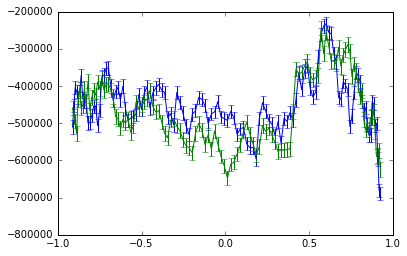

In [213]:
qidx=10
num_phi = 326
phi_off=20
# plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],GDPpro[qidx,phi_off:num_phi/2-phi_off]-GDPbuf[qidx,phi_off:num_phi/2-phi_off],
#                 yerr=GDPpro_errs[qidx,phi_off:num_phi/2-phi_off])

# plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],ALF_diff[qidx,phi_off:num_phi/2-phi_off],
#                 yerr=ALFerr[qidx,phi_off:num_phi/2-phi_off])
# # 
# plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],GDP_diff[qidx,phi_off:num_phi/2-phi_off]/2.,
#                 yerr=GDPerr[qidx,phi_off:num_phi/2-phi_off])
plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],GDPbuf[qidx,phi_off:num_phi/2-phi_off],
                yerr=GDPbuf_errs[qidx,phi_off:num_phi/2-phi_off])
# plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],GDPpro[qidx,phi_off:num_phi/2-phi_off],
#                 yerr=GDPpro_errs[qidx,phi_off:num_phi/2-phi_off])
plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],ALFbuf[qidx,phi_off:num_phi/2-phi_off],
                yerr=ALFbuf_errs[qidx,phi_off:num_phi/2-phi_off])

# plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],ALFpro[qidx,phi_off:num_phi/2-phi_off],
#                 yerr=ALFpro_errs[qidx,phi_off:num_phi/2-phi_off])

In [198]:
total_files = 0
sample = 'ALF_buf'
for ii, rr in enumerate(ALFbuf_runs):
    files = glob.glob('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/cali_gai_filtered2/%s/run%d_PCA-denoise*'%(sample,rr))
    n_files = len(files)
    for jj in range(n_files):
        print ALFbuf_pca[total_files+jj]
#         save_num_pca(rr, sample, ALFbuf_pca[total_files+jj], delete=True,
#                     file_num=jj)
    total_files+=n_files

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [196]:
n_files

0

In [ ]:
n_shots,cors,errs = get_cors(119,'ALF_buf',0)
n_shots2,cors2,errs2 = get_cors(119,'ALF_buf',1)
print n_shots, n_shots2

In [ ]:
cors.shape
# n_shots2
asyms=np.zeros((cors.shape[0],cors.shape[1]))

for ii in range(cors.shape[1]):
    asyms[:,ii]=compute_asym(cors[:,ii,:],phi_offset=phi_off, norm=True)
    
asyms2=np.zeros((cors.shape[0],cors.shape[1]))

for ii in range(cors.shape[1]):
    asyms2[:,ii]=compute_asym(cors2[:,ii,:],phi_offset=phi_off, norm=True)
# asym2=compute_asym(cors2)

In [ ]:
asyms.shape
plt.plot(asyms[qidx,:])
plt.plot(asyms2[qidx,:])

In [ ]:
qidx = 15
ii=asyms[qidx,2:].argmin()+2
print ii

plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],cors[qidx,ii,phi_off:num_phi/2-phi_off],
                yerr=errs[qidx,ii,phi_off:num_phi/2-phi_off])

ii2=asyms2[qidx,2:].argmin()+2
print ii2
# ii=7
plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],cors2[qidx,ii2,phi_off:num_phi/2-phi_off],
                yerr=errs2[qidx,ii,phi_off:num_phi/2-phi_off])

# plt.errorbar(cpsi[qidx,phi_off:num_phi/2-phi_off],(cors2[qidx,ii,phi_off:num_phi/2-phi_off]+cors[qidx,ii2,phi_off:num_phi/2-phi_off])*0.5,
#                 yerr=errs2[qidx,ii,phi_off:num_phi/2-phi_off])

In [ ]:
cors = []
errs=[]

cors2 = []
errs2=[]
for dd in range(20):
    cors.append(f['q0']['pca%d'%dd]['train_difcor'][0])
    
    errs.append(f['q0']['pca%d'%dd]['train_difcor_err'][0])
    cors2.append(f2['q0']['pca%d'%dd]['train_difcor'][0])
    errs2.append(f2['q0']['pca%d'%dd]['train_difcor_err'][0])
cors2=np.array(cors2)
errs2=np.array(errs2)
cors=np.array(cors)
errs=np.array(errs)


In [ ]:
cpsi=np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_cpsi.npy')[0]


In [ ]:
phi_off=30
num_phi = cors.shape[-1]

In [ ]:
plt.figure(figsize=[16,5])
for ii in [19]:
    plt.subplot(121)
#     plt.errorbar(cpsi[phi_off:num_phi/2-phi_off],cors[ii,phi_off:num_phi/2-phi_off],
#                 yerr=errs[ii,phi_off:num_phi/2-phi_off])
    
    plt.errorbar(cpsi[phi_off:num_phi/2-phi_off],cors2[ii,phi_off:num_phi/2-phi_off],
                yerr=errs2[ii,phi_off:num_phi/2-phi_off])
    
    plt.subplot(122)
    plt.errorbar(cpsi[phi_off:num_phi/2-phi_off],cors[ii,phi_off:num_phi/2-phi_off]-cors2[ii,phi_off:num_phi/2-phi_off],
                yerr=errs2[ii,phi_off:num_phi/2-phi_off])
    plt.vlines([-0.5,0,0.5],-4e8,2e8, linewidth=2, linestyle='--', alpha=0.5)
    dd = np.abs(cors[ii,phi_off:num_phi/2-phi_off]-cors2[ii,phi_off:num_phi/2-phi_off])
    ee=np.sqrt(errs[ii,phi_off:num_phi/2-phi_off]**2+errs2[ii,phi_off:num_phi/2-phi_off]**2)
    print ((dd/ee)>1).sum()/float(dd.shape[-1])
# plt.errorbar(cpsi[phi_off:num_phi/2-phi_off],cors[1][phi_off:num_phi/2-phi_off],
#             yerr=errs[1,phi_off:num_phi/2-phi_off])

In [ ]:
plt.errorbar(cpsi[phi_off:num_phi/2-phi_off],cors[ii,phi_off:num_phi/2-phi_off]-cors2[ii,phi_off:num_phi/2-phi_off],
                yerr=errs2[ii,phi_off:num_phi/2-phi_off])
# plt.errorbar(cpsi[phi_off:num_phi/2-phi_off],cors2[ii,phi_off:num_phi/2-phi_off],
#                 yerr=errs2[ii,phi_off:num_phi/2-phi_off])

In [ ]:
eigenimage=f['q3']['pca_components'].value
eigenimage2=f2['q3']['pca_components'].value

In [ ]:
plt.plot(eigenimage[3])
plt.plot(-eigenimage2[3])

In [ ]:
f2['q0']['num_shots'].value

In [ ]:
max_deg =30
deg = range(0,max_deg,2)
coef = []
cor_legfit = np.zeros_like(cors[:,phi_off:num_phi/2-phi_off])
for ii in range(cors.shape[0]):
    x=cpsi[phi_off:num_phi/2-phi_off]
    cc=legfit(x,cors2[ii,phi_off:num_phi/2-phi_off],deg)
    coef.append(cc)
    cor_legfit[ii] = legval(x,cc)
coef=np.array(coef)

In [ ]:
ii=10
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.errorbar(cpsi[phi_off:num_phi/2-phi_off],cors2[ii,phi_off:num_phi/2-phi_off],
                yerr=errs2[ii,phi_off:num_phi/2-phi_off])
plt.plot(cpsi[phi_off:num_phi/2-phi_off], cor_legfit[ii])

plt.subplot(122)
plt.plot(coef[ii])
# plt.plot(coef[ii,1::2])
# print np.abs(coef[ii,::2]).sum()/np.abs(coef[ii,1::2]).sum()

In [ ]:
y = (np.abs(coef[:,::2])/np.abs(coef[:,1::2])).sum(-1)
plt.plot(y)
y.argmax()

In [ ]:
y = np.abs(cors2[:, phi_off:num_phi/2-phi_off] - cor_legfit)/ errs2[:, phi_off:num_phi/2-phi_off]
plt.plot(y[0])
plt.plot(y[14])

In [ ]:
plt.plot(y.mean(-1))

In [207]:
d_buf = np.abs(GDPbuf -ALFbuf)/ np.sqrt( GDPbuf_errs**2+ ALFbuf_errs**2)
(d_buf>1).sum(-1)/d_buf

array([276, 282, 265, 260, 244, 233, 268, 266, 247, 266, 238, 238, 250,
       216, 247, 246, 244, 232, 240, 244, 247, 206, 257, 260, 231, 248,
       237, 256, 276, 260, 204, 226, 237, 234, 228, 241])

In [214]:
f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/cali_gai_cor_results/ALF_buf_chunks_split_maskDivide.h5','r')

In [215]:
f.keys()

[u'run118_0',
 u'run118_1',
 u'run119_0',
 u'run119_1',
 u'run119_2',
 u'run119_3',
 u'run122_0',
 u'run122_1',
 u'running_ave_cor',
 u'running_num_shots']

In [ ]:
x = f['running_ave_cor']